#### 定量的マクロ経済学と数値計算 第3章 動的計画法
#無限期間モデルの解法(状態変数が連続な場合): メインファイル

In [1]:
#必要な関数・モジュールを呼び出す
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from CRRA import CRRA, mu_CRRA
from BellmanEq import BellmanEq

In [2]:
#STEP 1(a): カリブレーション & グリッド生成
class Model():
    """
    モデルを解くためのパラメータを含む class を定義する。
    """
    def __init__(self,
        beta = 0.96,  # 割引因子
        gamma = 1.0,  # 相対的リスク回避度(異時点間の代替弾力性の逆数)
        alpha = 0.4,  # 資本分配率 
        delta = 1.0,  # 固定資本減耗
        nk = 21,      # 資本のグリッド数
        kmax = 0.5,   # 資本グリッドの最大値
        kmin = 0.05,  # 資本グリッドの最小値
        maxit = 1000, # 繰り返し計算の最大値
        tol = 1e-5,   # 許容誤差(STEP 4)
        ): 
        
        self.beta, self.gamma, self.alpha = beta, gamma, alpha 
        self.delta, self.nk = delta, nk 
        self.kmax, self.kmin = kmax, kmin 
        self.maxit, self.tol = maxit, tol
        self.kgrid = np.linspace(kmin,kmax,nk) # 資本のグリッド

#収束に関するパラメータ
it = 1 #ループ・カウンター
dif1 = 1.0 #価値関数の繰り返し誤差
dif2 = 1.0 #政策関数の繰り返し誤差

print("-+- Solve a Neoclassical Growth Model -+-")

#STEP 1(b): 価値関数・政策関数の初期値を設定
m = Model()
CRRA_vec = np.vectorize(CRRA) #CRRA関数をベクトル化する(配列を引数に取れるようにする)

vfcn0 = CRRA_vec(m,m.kgrid**m.alpha + (1-m.delta)*m.kgrid) #より良い価値関数の初期値を与える
pfcn0 = np.ones_like(vfcn0)
vfcn1 = np.zeros_like(vfcn0)
pfcn1 = np.zeros_like(vfcn0)
v_conv = [] #価値関数の繰り返し誤差を記録していく。各繰り返しごとにリストに追加していく。
p_conv = [] #政策関数の繰り返し誤差を記録していく。

-+- Solve a Neoclassical Growth Model -+-


In [3]:
#STEP 2: 価値関数を繰り返し計算
while (it<m.maxit) & (dif1>m.tol):

    #ベルマン方程式: V(k;k')
    for i in range(m.nk):
        
        capital = m.kgrid[i]
        v_interp = interp1d(m.kgrid,vfcn0,kind="cubic",fill_value="extrapolate") #価値関数について3次のスプライン補間
        Bellman = lambda x: BellmanEq(m,capital,x,v_interp) #ベルマン方程式をk'のみの関数にする
        
        #最適化関数(fmin)を使って、所与のkに対して最適なk'を探す(符号を反転させているので、"最小化"問題。)
        pfcn1[i] = fmin(Bellman,x0=0.01,disp=False)
        vfcn1[i] = -Bellman(pfcn1[i]) #符号を反転させる

    #繰り返し誤差を確認
    dif1 = np.max(np.abs((vfcn1-vfcn0)/vfcn0))
    dif2 = np.max(np.abs((pfcn1-pfcn0)/pfcn0)) 
    
    #価値関数・政策関数をアップデート
    vfcn0 = np.copy(vfcn1)
    pfcn0 = np.copy(pfcn1)

    print(f"iteration index: {it}")
    print(f"value function iteration error: {dif1:.7f}")
    print(f"policy function iteration error: {dif2:.7f}")

    #収束途中の繰り返し計算誤差を保存
    v_conv.append(dif1)
    p_conv.append(dif2)

    it += 1

#消費関数を政策関数を下に計算
cfcn = m.kgrid ** m.alpha + (1-m.delta)*m.kgrid - pfcn0

iteration index: 1
value function iteration error: 3.3317886
policy function iteration error: 0.9163750
iteration index: 2
value function iteration error: 0.8300218
policy function iteration error: 0.2532216
iteration index: 3
value function iteration error: 0.4511127
policy function iteration error: 0.0674365
iteration index: 4
value function iteration error: 0.3022973
policy function iteration error: 0.0231397
iteration index: 5
value function iteration error: 0.2239479
policy function iteration error: 0.0086130
iteration index: 6
value function iteration error: 0.1759961
policy function iteration error: 0.0034682
iteration index: 7
value function iteration error: 0.1437827
policy function iteration error: 0.0014680
iteration index: 8
value function iteration error: 0.1207173
policy function iteration error: 0.0007153
iteration index: 9
value function iteration error: 0.1034186
policy function iteration error: 0.0005394
iteration index: 10
value function iteration error: 0.0899810
po

In [4]:
#計算結果を表示
print("-+- PARAMETER VALUES -+-")
print(f"beta={m.beta}, gamma={m.gamma}, alpha={m.alpha}, delta={m.delta}")
print(f"kmin={m.kmin}, kmax={m.kmax}, grid={m.nk}")

-+- PARAMETER VALUES -+-
beta=0.96, gamma=1.0, alpha=0.4, delta=1.0
kmin=0.05, kmax=0.5, grid=21


In [5]:
#解析的解
AA = (1-m.beta)**(-1) * (np.log(1-m.alpha*m.beta) + ((m.alpha*m.beta)/(1-m.alpha*m.beta))*np.log(m.alpha*m.beta))
BB = m.alpha/(1-m.alpha*m.beta)
v_true = AA + BB*np.log(m.kgrid)
p_true = m.beta * m.alpha * (m.kgrid ** m.alpha)

In [6]:
#オイラー方程式から誤差を計算
mu_CRRA_vec = np.vectorize(mu_CRRA) #mu_CRRA関数をベクトル化する
LHS = mu_CRRA(m,cfcn) #今期の消費水準についての限界効用
kp_interp = interp1d(m.kgrid,pfcn0,kind="linear",fill_value="extrapolate") #政策関数を補間する
cons_p = (pfcn0 ** m.alpha) + (1-m.delta)*pfcn0 - kp_interp(pfcn0)
rent = m.alpha*(pfcn0**(m.alpha-1)) -m.delta #r=f'(k)-\delta
RHS = m.beta*(1+rent) * mu_CRRA_vec(m,cons_p)
err = (RHS/LHS) - 1

f = open("err_ddp.csv",encoding='utf-8-sig')
err2 = np.loadtxt(f) #離散化した場合のオイラー方程式誤差

#### 図を描く

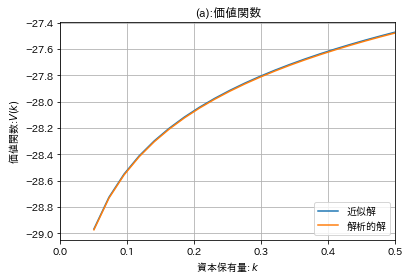

In [7]:
fig, ax = plt.subplots()
ax.plot(m.kgrid,vfcn0,label="近似解")
ax.plot(m.kgrid,v_true,label="解析的解")
ax.set(title="(a):価値関数",xlabel=r"資本保有量: $k$", ylabel=r"価値関数:$V(k)$",xlim=(0,m.kmax))
ax.legend(loc="lower right")
ax.grid()
plt.show()

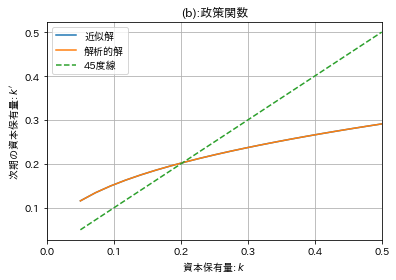

In [8]:
fig, ax = plt.subplots()
ax.plot(m.kgrid, pfcn0, label="近似解")
ax.plot(m.kgrid, p_true, label="解析的解")
ax.plot(m.kgrid, m.kgrid, ls="--", label="45度線")
ax.set(title="(b):政策関数",xlabel=r"資本保有量: $k$", ylabel=r"次期の資本保有量: $k'$",xlim=(0,m.kmax))
ax.legend(loc="upper left")
ax.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


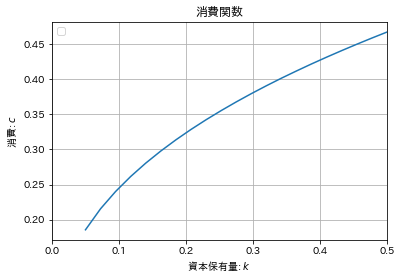

In [9]:
fig, ax = plt.subplots()
ax.plot(m.kgrid, cfcn)
ax.set(title="消費関数",xlabel=r"資本保有量: $k$", ylabel=r"消費: $c$",xlim=(0,m.kmax))
ax.legend(loc="upper left")
ax.grid()
plt.show()

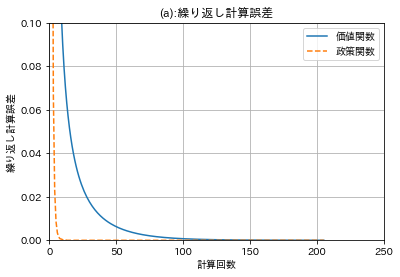

In [10]:
iter = np.linspace(1,it-1,it-1)

fig, ax = plt.subplots()
ax.plot(iter,v_conv,label="価値関数")
ax.plot(iter,p_conv,label="政策関数",ls="--")
ax.set(xlabel="計算回数", ylabel="繰り返し計算誤差", title="(a):繰り返し計算誤差",xlim=(0,250),ylim=(0,0.1))
ax.grid()
ax.legend(loc="upper right")
plt.show()

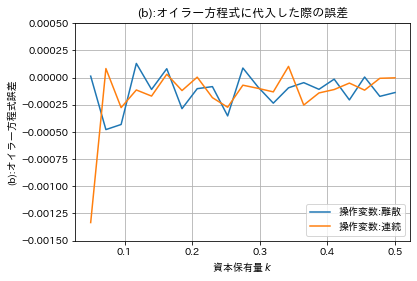

In [13]:
fig, ax = plt.subplots()
ax.plot(m.kgrid,err2,label="操作変数:離散")
ax.plot(m.kgrid,err,label="操作変数:連続")
ax.set(xlabel=r"資本保有量 $k$", ylabel="(b):オイラー方程式誤差",ylim=(-15e-4,5e-4),title="(b):オイラー方程式に代入した際の誤差")
ax.legend(loc="lower right")
ax.grid()
plt.show()